In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot

import shap
from catboost import CatBoostRegressor, Pool

plt.style.use('fivethirtyeight')

pd.set_option('display.max_rows', 500)

pyplot.rcParams["figure.figsize"] = (20,10)

In [2]:
import matplotlib.pyplot as plt
def trading(forecast,actual):
#execute the trading from the result of forecast and actual energy production
#forecast: an 1D array of forecast values (Unit:kWh)
#actual: an 1D array of actual values (Unit:kWh)
  
    #initial budget
    budget=1e9
    #counters initialize: short falling and panalty counter
    SFcount=0;
    Pcount=0;
    cashFlow=[1e9]
    
    for f,a in zip(forecast,actual):
        if f <= a:
            budget += f*10
        elif f > a:#short falling
            #calculate cost of spot price energy
            budget += a*10
            spotP = 20*(f-a)
            SFcount+= 1
            if budget >= spotP:
                budget -= 20*(f-a)
            else:
                #receive penalty from the government
                if budget>0:
                    #buy from grid if budget not equal to 0
                    spotP-=budget
                    budget=0
                #fine =5* spotP
                budget -= 5*spotP
                Pcount+=1
        cashFlow.append(budget)
    timeStep= list(range(0, len(cashFlow)))
    #Reporting
    plt.plot(timeStep,cashFlow)
    plt.show()
    print ("resultant budget: ",budget)
    print ("net profit: ",budget-1e9)
    print ("number of short falling: ",SFcount )
    print ("number of panalty: ",Pcount )
    #print ("Cash flow: ",cashFlow )

In [3]:
df = pd.read_csv("combined_energy_data.csv", low_memory=False)

In [4]:
df = df.drop_duplicates(subset=['datetime'])

In [5]:
df['datetime'] = df['datetime'].apply(lambda x: x.split("+")[0])

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df = df[df.Consumption.notnull()]

In [8]:
df.columns

Index(['Perimeter', 'Nature', 'Dated', 'Hours', 'Consumption', 'Thermal',
       'Wind', 'Solar', 'Hydraulic', 'Bioenergies', 'Ech. physical',
       'datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b

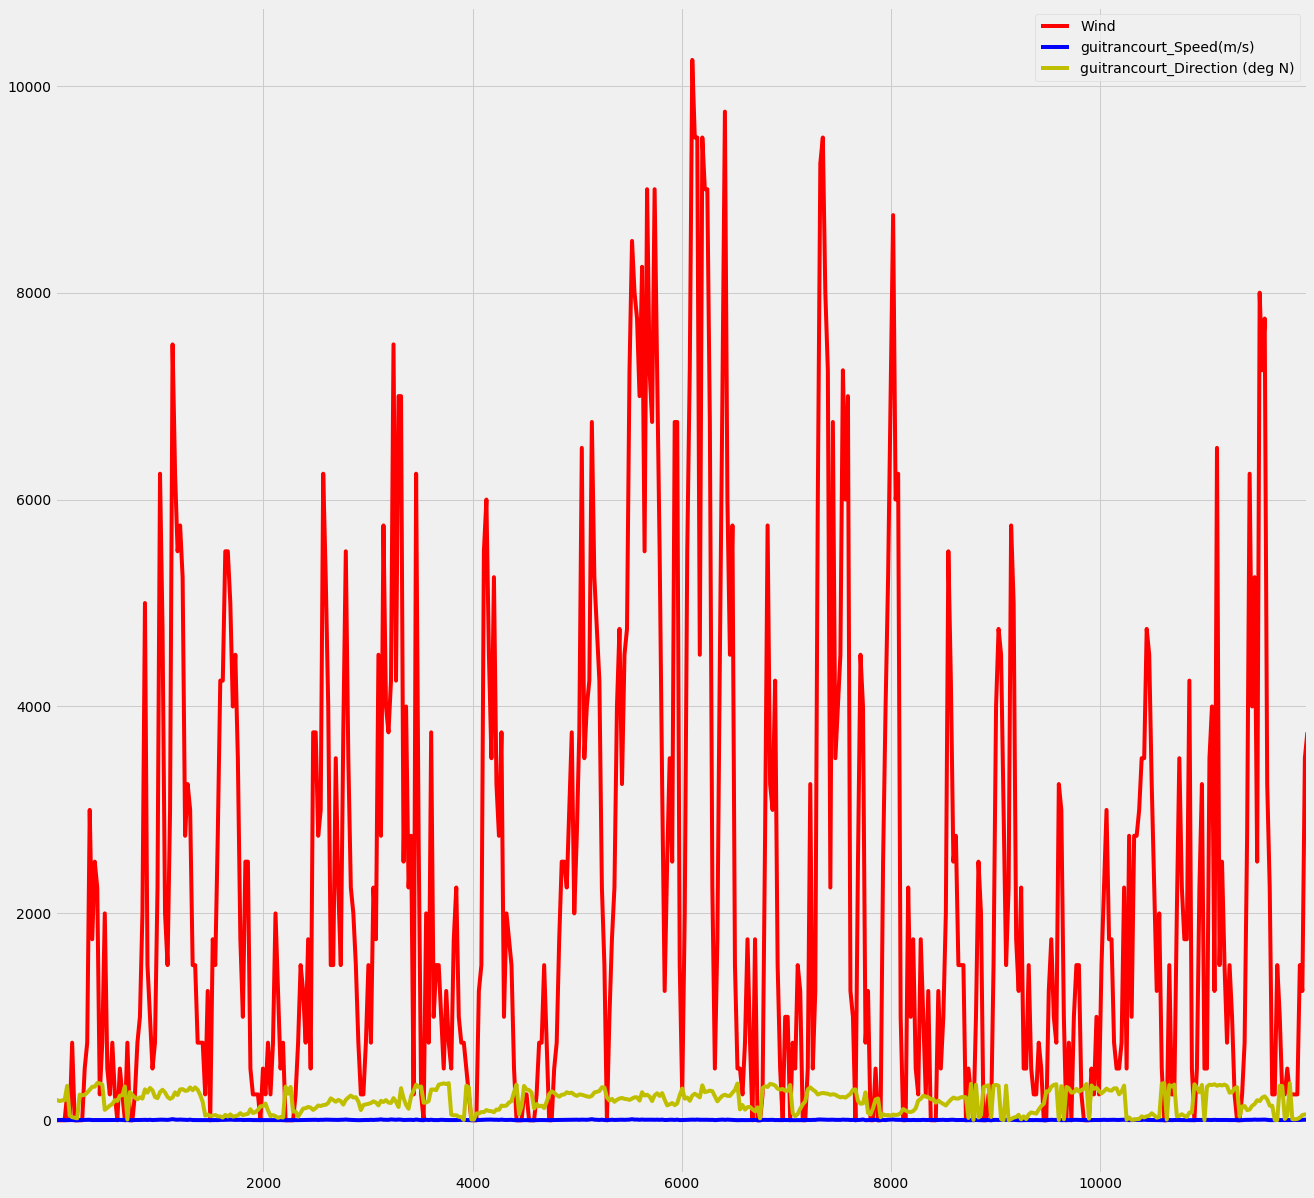

In [9]:
df[df['guitrancourt_Speed(m/s)'].notnull()].head(500)[['Wind','guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)']].astype(float).plot(style=['r','b','y'],figsize=(20,20))

In [10]:
columns_use = ['datetime', 'guitrancourt_Speed(m/s)', 'guitrancourt_Direction (deg N)',
       'lieusaint_Speed(m/s)', 'lieusaint_Direction (deg N)',
       'lvs-pussay_Speed(m/s)', 'lvs-pussay_Direction (deg N)',
       'parc-du-gatinais_Speed(m/s)', 'parc-du-gatinais_Direction (deg N)',
       'arville_Speed(m/s)', 'arville_Direction (deg N)',
       'boissy-la-riviere_Speed(m/s)', 'boissy-la-riviere_Direction (deg N)',
       'angerville-1_Speed(m/s)', 'angerville-1_Direction (deg N)',
       'angerville-2_Speed(m/s)', 'angerville-2_Direction (deg N)',
       'guitrancourt-b_Speed(m/s)', 'guitrancourt-b_Direction (deg N)',
       'lieusaint-b_Speed(m/s)', 'lieusaint-b_Direction (deg N)',
       'lvs-pussay-b_Speed(m/s)', 'lvs-pussay-b_Direction (deg N)',
       'parc-du-gatinais-b_Speed(m/s)', 'parc-du-gatinais-b_Direction (deg N)',
       'arville-b_Speed(m/s)', 'arville-b_Direction (deg N)',
       'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Direction (deg N)', 'angerville-1-b_Speed(m/s)',
       'angerville-1-b_Direction (deg N)', 'angerville-2-b_Speed(m/s)',
       'angerville-2-b_Direction (deg N)']

In [11]:
agg_df = df[['datetime','Wind']].groupby([df['datetime'].dt.floor('H')]).agg(['mean','sum','std'])
agg_df.columns = agg_df.columns.map('_'.join)
agg_df = agg_df.reset_index()
merge_df = agg_df.merge(df[columns_use], how='left', on='datetime')
merge_df = merge_df.fillna(method='ffill')
data = merge_df.copy()

In [12]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [13]:
#data['PJM_Load_MW_mean_halfday'] = data['PJM_Load_MW'].rolling(12).mean()
data['Wind_sum_mean_daily'] = data['Wind_sum'].rolling(24).mean()
data['Wind_sum_mean_weekly'] = data['Wind_sum'].rolling(24*7).mean()
data['Wind_sum_mean_monthly'] = data['Wind_sum'].rolling(24*30).mean()

In [14]:
data['Wind_sum_std_daily'] = data['Wind_sum'].rolling(24).std()
data['Wind_sum_std_weekly'] = data['Wind_sum'].rolling(24*7).std()
data['Wind_sum_std_monthly'] = data['Wind_sum'].rolling(24*30).std()

In [15]:
data['hour'] = data['datetime'].dt.hour
data['dayofweek'] = data['datetime'].dt.dayofweek
data['quarter'] = data['datetime'].dt.quarter
data['month'] = data['datetime'].dt.month
data['year'] = data['datetime'].dt.year 
data['dayofyear'] = data['datetime'].dt.dayofyear
data['dayofmonth'] = data['datetime'].dt.day
data['weekofyear'] = data['datetime'].dt.weekofyear

In [16]:
data['target'] = data['Wind_sum'].shift(-18)

In [17]:
data.dropna(axis=0, how='any', inplace=True)

In [18]:
np.sqrt(mean_squared_error(y_true=data['target'],y_pred=data['Wind_sum']))

9528.08196811996

In [19]:
mean_absolute_error(y_true=data['target'],y_pred=data['Wind_sum'])

6506.450067721582

In [20]:
data = data.drop(columns=['datetime'])

In [21]:
X_train = data[data.year.isin([2017,2018])].drop(columns=['target','year','month'])
X_test = data[data.year.isin([2019])].drop(columns=['target','year','month'])
y_train = data[data.year.isin([2017,2018])][['target']]
y_test = data[data.year.isin([2019])][['target']]

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [190]:
X_train.columns

Index(['Wind_mean', 'Wind_sum', 'Wind_std', 'guitrancourt_Speed(m/s)',
       'guitrancourt_Direction (deg N)', 'lieusaint_Speed(m/s)',
       'lieusaint_Direction (deg N)', 'lvs-pussay_Speed(m/s)',
       'lvs-pussay_Direction (deg N)', 'parc-du-gatinais_Speed(m/s)',
       'parc-du-gatinais_Direction (deg N)', 'arville_Speed(m/s)',
       'arville_Direction (deg N)', 'boissy-la-riviere_Speed(m/s)',
       'boissy-la-riviere_Direction (deg N)', 'angerville-1_Speed(m/s)',
       'angerville-1_Direction (deg N)', 'angerville-2_Speed(m/s)',
       'angerville-2_Direction (deg N)', 'guitrancourt-b_Speed(m/s)',
       'guitrancourt-b_Direction (deg N)', 'lieusaint-b_Speed(m/s)',
       'lieusaint-b_Direction (deg N)', 'lvs-pussay-b_Speed(m/s)',
       'lvs-pussay-b_Direction (deg N)', 'parc-du-gatinais-b_Speed(m/s)',
       'parc-du-gatinais-b_Direction (deg N)', 'arville-b_Speed(m/s)',
       'arville-b_Direction (deg N)', 'boissy-la-riviere-b_Speed(m/s)',
       'boissy-la-riviere-b_Dire

In [184]:
reg = CatBoostRegressor(iterations = 10000, 
                        learning_rate = 0.005, 
                        loss_function = "RMSE",
                        max_depth = 1,
                        task_type = "GPU",
                        random_seed = 42
                       )

In [191]:
reg.fit(X_train, y_train, cat_features = ['hour', 'dayofweek','dayofmonth'], eval_set=[(X_test, y_test)],early_stopping_rounds=50)

0:	learn: 6575.6370564	test: 11346.5681073	best: 11346.5681073 (0)	total: 15.9ms	remaining: 2m 39s
1:	learn: 6570.5453545	test: 11337.8393292	best: 11337.8393292 (1)	total: 30.2ms	remaining: 2m 31s
2:	learn: 6565.4850565	test: 11330.3414127	best: 11330.3414127 (2)	total: 44.1ms	remaining: 2m 27s
3:	learn: 6560.5052906	test: 11323.0922756	best: 11323.0922756 (3)	total: 60ms	remaining: 2m 30s
4:	learn: 6555.4714590	test: 11314.9815354	best: 11314.9815354 (4)	total: 75.1ms	remaining: 2m 30s
5:	learn: 6550.5311267	test: 11306.2376362	best: 11306.2376362 (5)	total: 89.5ms	remaining: 2m 29s
6:	learn: 6545.6082225	test: 11298.1677759	best: 11298.1677759 (6)	total: 105ms	remaining: 2m 30s
7:	learn: 6540.7889665	test: 11291.7594196	best: 11291.7594196 (7)	total: 120ms	remaining: 2m 29s
8:	learn: 6536.0288255	test: 11285.0643217	best: 11285.0643217 (8)	total: 134ms	remaining: 2m 28s
9:	learn: 6531.1675602	test: 11277.1783541	best: 11277.1783541 (9)	total: 149ms	remaining: 2m 29s
10:	learn: 6526.

90:	learn: 6229.9402183	test: 10784.6832644	best: 10784.6832644 (90)	total: 1.31s	remaining: 2m 23s
91:	learn: 6227.0739282	test: 10778.4423492	best: 10778.4423492 (91)	total: 1.33s	remaining: 2m 23s
92:	learn: 6224.2342079	test: 10772.2464386	best: 10772.2464386 (92)	total: 1.35s	remaining: 2m 23s
93:	learn: 6221.4217208	test: 10766.0966529	best: 10766.0966529 (93)	total: 1.36s	remaining: 2m 23s
94:	learn: 6218.6976655	test: 10762.3886878	best: 10762.3886878 (94)	total: 1.38s	remaining: 2m 23s
95:	learn: 6215.9231521	test: 10756.3031745	best: 10756.3031745 (95)	total: 1.39s	remaining: 2m 23s
96:	learn: 6213.0977989	test: 10752.1475262	best: 10752.1475262 (96)	total: 1.41s	remaining: 2m 23s
97:	learn: 6210.3145023	test: 10747.7904763	best: 10747.7904763 (97)	total: 1.42s	remaining: 2m 23s
98:	learn: 6207.6459006	test: 10744.3338569	best: 10744.3338569 (98)	total: 1.44s	remaining: 2m 23s
99:	learn: 6204.9346580	test: 10738.3548208	best: 10738.3548208 (99)	total: 1.45s	remaining: 2m 23s


178:	learn: 6035.3139211	test: 10438.0140469	best: 10438.0140469 (178)	total: 2.6s	remaining: 2m 22s
179:	learn: 6033.6590266	test: 10435.6454190	best: 10435.6454190 (179)	total: 2.62s	remaining: 2m 22s
180:	learn: 6032.0085285	test: 10432.8918585	best: 10432.8918585 (180)	total: 2.63s	remaining: 2m 22s
181:	learn: 6030.3773086	test: 10430.4632461	best: 10430.4632461 (181)	total: 2.65s	remaining: 2m 22s
182:	learn: 6028.7327061	test: 10426.3600022	best: 10426.3600022 (182)	total: 2.67s	remaining: 2m 22s
183:	learn: 6027.1701770	test: 10421.7253195	best: 10421.7253195 (183)	total: 2.68s	remaining: 2m 22s
184:	learn: 6025.5188726	test: 10418.9731071	best: 10418.9731071 (184)	total: 2.69s	remaining: 2m 22s
185:	learn: 6023.9150364	test: 10416.6163109	best: 10416.6163109 (185)	total: 2.71s	remaining: 2m 22s
186:	learn: 6022.2887495	test: 10413.9367513	best: 10413.9367513 (186)	total: 2.72s	remaining: 2m 22s
187:	learn: 6020.7170970	test: 10411.1950565	best: 10411.1950565 (187)	total: 2.73s

267:	learn: 5915.1542794	test: 10197.3415369	best: 10197.3415369 (267)	total: 3.89s	remaining: 2m 21s
268:	learn: 5914.0779028	test: 10195.5367593	best: 10195.5367593 (268)	total: 3.9s	remaining: 2m 21s
269:	learn: 5912.9825281	test: 10192.1064710	best: 10192.1064710 (269)	total: 3.92s	remaining: 2m 21s
270:	learn: 5911.9206026	test: 10189.1361940	best: 10189.1361940 (270)	total: 3.94s	remaining: 2m 21s
271:	learn: 5910.8825750	test: 10188.2079655	best: 10188.2079655 (271)	total: 3.95s	remaining: 2m 21s
272:	learn: 5909.8120212	test: 10184.8321432	best: 10184.8321432 (272)	total: 3.96s	remaining: 2m 21s
273:	learn: 5908.7614095	test: 10182.8726836	best: 10182.8726836 (273)	total: 3.98s	remaining: 2m 21s
274:	learn: 5907.7228268	test: 10181.5970321	best: 10181.5970321 (274)	total: 3.99s	remaining: 2m 21s
275:	learn: 5906.5988654	test: 10179.3510270	best: 10179.3510270 (275)	total: 4.01s	remaining: 2m 21s
276:	learn: 5905.5483426	test: 10175.9171207	best: 10175.9171207 (276)	total: 4.03s

351:	learn: 5837.3333090	test: 10024.0671198	best: 10024.0671198 (351)	total: 5.18s	remaining: 2m 22s
352:	learn: 5836.5747659	test: 10022.8350831	best: 10022.8350831 (352)	total: 5.2s	remaining: 2m 22s
353:	learn: 5835.8431964	test: 10020.4653846	best: 10020.4653846 (353)	total: 5.22s	remaining: 2m 22s
354:	learn: 5835.0660750	test: 10019.7548885	best: 10019.7548885 (354)	total: 5.24s	remaining: 2m 22s
355:	learn: 5834.2968735	test: 10019.0506897	best: 10019.0506897 (355)	total: 5.25s	remaining: 2m 22s
356:	learn: 5833.5422822	test: 10018.0622636	best: 10018.0622636 (356)	total: 5.27s	remaining: 2m 22s
357:	learn: 5832.7839149	test: 10017.0225746	best: 10017.0225746 (357)	total: 5.28s	remaining: 2m 22s
358:	learn: 5832.0257835	test: 10014.3186539	best: 10014.3186539 (358)	total: 5.3s	remaining: 2m 22s
359:	learn: 5831.3033433	test: 10012.9789361	best: 10012.9789361 (359)	total: 5.31s	remaining: 2m 22s
360:	learn: 5830.5590695	test: 10011.9540393	best: 10011.9540393 (360)	total: 5.32s	

439:	learn: 5778.5099414	test: 9897.3119660	best: 9897.3119660 (439)	total: 6.46s	remaining: 2m 20s
440:	learn: 5777.9330574	test: 9895.7537763	best: 9895.7537763 (440)	total: 6.48s	remaining: 2m 20s
441:	learn: 5777.3520644	test: 9893.6085015	best: 9893.6085015 (441)	total: 6.5s	remaining: 2m 20s
442:	learn: 5776.7770906	test: 9893.0696521	best: 9893.0696521 (442)	total: 6.52s	remaining: 2m 20s
443:	learn: 5776.2280604	test: 9892.2932792	best: 9892.2932792 (443)	total: 6.54s	remaining: 2m 20s
444:	learn: 5775.6577026	test: 9891.0444504	best: 9891.0444504 (444)	total: 6.56s	remaining: 2m 20s
445:	learn: 5775.1291680	test: 9891.3001290	best: 9891.0444504 (444)	total: 6.57s	remaining: 2m 20s
446:	learn: 5774.5691725	test: 9890.4657452	best: 9890.4657452 (446)	total: 6.59s	remaining: 2m 20s
447:	learn: 5773.9820984	test: 9889.8382090	best: 9889.8382090 (447)	total: 6.61s	remaining: 2m 20s
448:	learn: 5773.4148970	test: 9887.7279728	best: 9887.7279728 (448)	total: 6.62s	remaining: 2m 20s
4

524:	learn: 5735.4073945	test: 9815.4481719	best: 9815.4481719 (524)	total: 7.78s	remaining: 2m 20s
525:	learn: 5734.9839839	test: 9815.1634557	best: 9815.1634557 (525)	total: 7.79s	remaining: 2m 20s
526:	learn: 5734.5591815	test: 9812.0302697	best: 9812.0302697 (526)	total: 7.81s	remaining: 2m 20s
527:	learn: 5734.0720995	test: 9811.4842709	best: 9811.4842709 (527)	total: 7.82s	remaining: 2m 20s
528:	learn: 5733.6094693	test: 9809.6569369	best: 9809.6569369 (528)	total: 7.84s	remaining: 2m 20s
529:	learn: 5733.1270696	test: 9809.1153827	best: 9809.1153827 (529)	total: 7.85s	remaining: 2m 20s
530:	learn: 5732.6929432	test: 9808.4280997	best: 9808.4280997 (530)	total: 7.87s	remaining: 2m 20s
531:	learn: 5732.2757970	test: 9806.7012891	best: 9806.7012891 (531)	total: 7.88s	remaining: 2m 20s
532:	learn: 5731.8324184	test: 9806.9435263	best: 9806.7012891 (531)	total: 7.89s	remaining: 2m 20s
533:	learn: 5731.3873038	test: 9806.0867046	best: 9806.0867046 (533)	total: 7.91s	remaining: 2m 20s


608:	learn: 5701.3984049	test: 9743.7498764	best: 9743.7498764 (608)	total: 9.06s	remaining: 2m 19s
609:	learn: 5701.0763041	test: 9743.0994515	best: 9743.0994515 (609)	total: 9.07s	remaining: 2m 19s
610:	learn: 5700.7050872	test: 9743.3352067	best: 9743.0994515 (609)	total: 9.09s	remaining: 2m 19s
611:	learn: 5700.3348727	test: 9742.8045574	best: 9742.8045574 (611)	total: 9.1s	remaining: 2m 19s
612:	learn: 5699.9292173	test: 9742.3268714	best: 9742.3268714 (612)	total: 9.12s	remaining: 2m 19s
613:	learn: 5699.7468255	test: 9742.1471572	best: 9742.1471572 (613)	total: 9.13s	remaining: 2m 19s
614:	learn: 5699.3849332	test: 9741.4025364	best: 9741.4025364 (614)	total: 9.15s	remaining: 2m 19s
615:	learn: 5699.0219913	test: 9740.6509455	best: 9740.6509455 (615)	total: 9.16s	remaining: 2m 19s
616:	learn: 5698.6809314	test: 9739.9849499	best: 9739.9849499 (616)	total: 9.17s	remaining: 2m 19s
617:	learn: 5698.3564521	test: 9739.2781920	best: 9739.2781920 (617)	total: 9.19s	remaining: 2m 19s
6

697:	learn: 5673.1236284	test: 9680.2376075	best: 9680.2376075 (697)	total: 10.4s	remaining: 2m 18s
698:	learn: 5672.7835902	test: 9679.8175117	best: 9679.8175117 (698)	total: 10.4s	remaining: 2m 17s
699:	learn: 5672.4689765	test: 9677.3742564	best: 9677.3742564 (699)	total: 10.4s	remaining: 2m 17s
700:	learn: 5672.1849496	test: 9677.1747798	best: 9677.1747798 (700)	total: 10.4s	remaining: 2m 17s
701:	learn: 5671.8943747	test: 9676.8821293	best: 9676.8821293 (701)	total: 10.4s	remaining: 2m 17s
702:	learn: 5671.6204642	test: 9676.3455160	best: 9676.3455160 (702)	total: 10.4s	remaining: 2m 17s
703:	learn: 5671.3293445	test: 9675.0146792	best: 9675.0146792 (703)	total: 10.4s	remaining: 2m 17s
704:	learn: 5670.9928100	test: 9674.5978368	best: 9674.5978368 (704)	total: 10.5s	remaining: 2m 17s
705:	learn: 5670.6593513	test: 9674.1832967	best: 9674.1832967 (705)	total: 10.5s	remaining: 2m 17s
706:	learn: 5670.3731699	test: 9673.8951963	best: 9673.8951963 (706)	total: 10.5s	remaining: 2m 17s


787:	learn: 5650.5835397	test: 9637.1875326	best: 9637.1875326 (787)	total: 11.7s	remaining: 2m 16s
788:	learn: 5650.3401816	test: 9636.8579531	best: 9636.8579531 (788)	total: 11.7s	remaining: 2m 16s
789:	learn: 5650.0645357	test: 9634.6604682	best: 9634.6604682 (789)	total: 11.7s	remaining: 2m 16s
790:	learn: 5649.8101079	test: 9634.3172115	best: 9634.3172115 (790)	total: 11.7s	remaining: 2m 16s
791:	learn: 5649.5713773	test: 9633.8671540	best: 9633.8671540 (791)	total: 11.7s	remaining: 2m 16s
792:	learn: 5649.4229207	test: 9633.8807453	best: 9633.8671540 (791)	total: 11.7s	remaining: 2m 16s
793:	learn: 5649.1501648	test: 9631.7054975	best: 9631.7054975 (793)	total: 11.8s	remaining: 2m 16s
794:	learn: 5649.0218960	test: 9631.8907680	best: 9631.7054975 (793)	total: 11.8s	remaining: 2m 16s
795:	learn: 5648.7501566	test: 9631.5454705	best: 9631.5454705 (795)	total: 11.8s	remaining: 2m 16s
796:	learn: 5648.6035776	test: 9631.5594536	best: 9631.5454705 (795)	total: 11.8s	remaining: 2m 16s


873:	learn: 5633.3510068	test: 9599.2245742	best: 9599.2245742 (873)	total: 12.9s	remaining: 2m 15s
874:	learn: 5633.2379592	test: 9599.4015082	best: 9599.2245742 (873)	total: 13s	remaining: 2m 15s
875:	learn: 5632.9919473	test: 9599.6103951	best: 9599.2245742 (873)	total: 13s	remaining: 2m 15s
876:	learn: 5632.8596746	test: 9599.6291012	best: 9599.2245742 (873)	total: 13s	remaining: 2m 15s
877:	learn: 5632.5978903	test: 9599.2791357	best: 9599.2245742 (873)	total: 13s	remaining: 2m 15s
878:	learn: 5632.4848276	test: 9599.1863810	best: 9599.1863810 (878)	total: 13s	remaining: 2m 15s
879:	learn: 5632.2708160	test: 9598.9657928	best: 9598.9657928 (879)	total: 13s	remaining: 2m 15s
880:	learn: 5632.0318614	test: 9598.5822845	best: 9598.5822845 (880)	total: 13.1s	remaining: 2m 15s
881:	learn: 5631.8188715	test: 9598.1675794	best: 9598.1675794 (881)	total: 13.1s	remaining: 2m 15s
882:	learn: 5631.7348855	test: 9598.0989799	best: 9598.0989799 (882)	total: 13.1s	remaining: 2m 15s
883:	learn: 

958:	learn: 5618.7065626	test: 9571.2685799	best: 9571.2685799 (958)	total: 14.2s	remaining: 2m 14s
959:	learn: 5618.6065854	test: 9571.4378226	best: 9571.2685799 (958)	total: 14.2s	remaining: 2m 14s
960:	learn: 5618.3776381	test: 9571.6398937	best: 9571.2685799 (958)	total: 14.3s	remaining: 2m 14s
961:	learn: 5618.1866968	test: 9570.6345771	best: 9570.6345771 (961)	total: 14.3s	remaining: 2m 14s
962:	learn: 5617.9660648	test: 9568.8120739	best: 9568.8120739 (962)	total: 14.3s	remaining: 2m 14s
963:	learn: 5617.7407369	test: 9568.5141543	best: 9568.5141543 (963)	total: 14.3s	remaining: 2m 14s
964:	learn: 5617.6334512	test: 9568.3866951	best: 9568.3866951 (964)	total: 14.3s	remaining: 2m 13s
965:	learn: 5617.4152280	test: 9567.8983462	best: 9567.8983462 (965)	total: 14.3s	remaining: 2m 13s
966:	learn: 5617.1923087	test: 9567.5968790	best: 9567.5968790 (966)	total: 14.3s	remaining: 2m 13s
967:	learn: 5617.0034106	test: 9566.4656080	best: 9566.4656080 (967)	total: 14.3s	remaining: 2m 13s


1047:	learn: 5604.4468875	test: 9539.8109451	best: 9539.8109451 (1047)	total: 15.5s	remaining: 2m 12s
1048:	learn: 5604.3760643	test: 9539.7870237	best: 9539.7870237 (1048)	total: 15.5s	remaining: 2m 12s
1049:	learn: 5604.2090087	test: 9539.6615336	best: 9539.6615336 (1049)	total: 15.5s	remaining: 2m 12s
1050:	learn: 5604.1099911	test: 9539.5497676	best: 9539.5497676 (1050)	total: 15.6s	remaining: 2m 12s
1051:	learn: 5604.0151483	test: 9539.4329020	best: 9539.4329020 (1051)	total: 15.6s	remaining: 2m 12s
1052:	learn: 5603.8397285	test: 9539.1430850	best: 9539.1430850 (1052)	total: 15.6s	remaining: 2m 12s
1053:	learn: 5603.6764857	test: 9538.7967833	best: 9538.7967833 (1053)	total: 15.6s	remaining: 2m 12s
1054:	learn: 5603.4881762	test: 9538.3543773	best: 9538.3543773 (1054)	total: 15.6s	remaining: 2m 12s
1055:	learn: 5603.2934207	test: 9536.7092943	best: 9536.7092943 (1055)	total: 15.6s	remaining: 2m 12s
1056:	learn: 5603.0849081	test: 9536.9046480	best: 9536.7092943 (1055)	total: 15.6

1139:	learn: 5591.3487024	test: 9514.2506741	best: 9514.2506741 (1139)	total: 16.8s	remaining: 2m 10s
1140:	learn: 5591.2525967	test: 9514.2785917	best: 9514.2506741 (1139)	total: 16.8s	remaining: 2m 10s
1141:	learn: 5591.1702688	test: 9514.1684935	best: 9514.1684935 (1141)	total: 16.8s	remaining: 2m 10s
1142:	learn: 5591.1174179	test: 9514.1217014	best: 9514.1217014 (1142)	total: 16.9s	remaining: 2m 10s
1143:	learn: 5591.0404954	test: 9514.0406994	best: 9514.0406994 (1143)	total: 16.9s	remaining: 2m 10s
1144:	learn: 5590.8746112	test: 9513.6030407	best: 9513.6030407 (1144)	total: 16.9s	remaining: 2m 10s
1145:	learn: 5590.7116876	test: 9513.3014260	best: 9513.3014260 (1145)	total: 16.9s	remaining: 2m 10s
1146:	learn: 5590.6171408	test: 9513.3301329	best: 9513.3014260 (1145)	total: 16.9s	remaining: 2m 10s
1147:	learn: 5590.4264725	test: 9513.5208546	best: 9513.3014260 (1145)	total: 16.9s	remaining: 2m 10s
1148:	learn: 5590.2832490	test: 9513.1063740	best: 9513.1063740 (1148)	total: 16.9

1225:	learn: 5579.8966503	test: 9492.2694107	best: 9492.2694107 (1225)	total: 18.1s	remaining: 2m 9s
1226:	learn: 5579.7376009	test: 9490.8788635	best: 9490.8788635 (1226)	total: 18.1s	remaining: 2m 9s
1227:	learn: 5579.6493353	test: 9490.9080324	best: 9490.8788635 (1226)	total: 18.1s	remaining: 2m 9s
1228:	learn: 5579.5044368	test: 9490.4901991	best: 9490.4901991 (1228)	total: 18.1s	remaining: 2m 9s
1229:	learn: 5579.3312178	test: 9490.6758612	best: 9490.4901991 (1228)	total: 18.1s	remaining: 2m 9s
1230:	learn: 5579.1588675	test: 9490.8615198	best: 9490.4901991 (1228)	total: 18.1s	remaining: 2m 9s
1231:	learn: 5579.0898210	test: 9490.7795309	best: 9490.4901991 (1228)	total: 18.2s	remaining: 2m 9s
1232:	learn: 5579.0164035	test: 9490.6829565	best: 9490.4901991 (1228)	total: 18.2s	remaining: 2m 9s
1233:	learn: 5578.8599511	test: 9489.3083407	best: 9489.3083407 (1233)	total: 18.2s	remaining: 2m 9s
1234:	learn: 5578.6844396	test: 9489.4124195	best: 9489.3083407 (1233)	total: 18.2s	remaini

1313:	learn: 5569.6722612	test: 9475.8725865	best: 9475.8725865 (1313)	total: 19.4s	remaining: 2m 7s
1314:	learn: 5569.6094007	test: 9476.0139235	best: 9475.8725865 (1313)	total: 19.4s	remaining: 2m 7s
1315:	learn: 5569.4644161	test: 9474.7177286	best: 9474.7177286 (1315)	total: 19.4s	remaining: 2m 7s
1316:	learn: 5569.4134604	test: 9474.6987759	best: 9474.6987759 (1316)	total: 19.4s	remaining: 2m 7s
1317:	learn: 5569.3157504	test: 9474.3963175	best: 9474.3963175 (1317)	total: 19.4s	remaining: 2m 7s
1318:	learn: 5569.1987763	test: 9473.2720825	best: 9473.2720825 (1318)	total: 19.4s	remaining: 2m 7s
1319:	learn: 5569.0637626	test: 9472.8724277	best: 9472.8724277 (1319)	total: 19.4s	remaining: 2m 7s
1320:	learn: 5568.9065053	test: 9473.0548809	best: 9472.8724277 (1319)	total: 19.4s	remaining: 2m 7s
1321:	learn: 5568.8336541	test: 9472.9443036	best: 9472.8724277 (1319)	total: 19.5s	remaining: 2m 7s
1322:	learn: 5568.7693831	test: 9472.8518916	best: 9472.8518916 (1322)	total: 19.5s	remaini

1402:	learn: 5559.4795892	test: 9458.6199502	best: 9458.6037339 (1400)	total: 20.6s	remaining: 2m 6s
1403:	learn: 5559.4418740	test: 9458.5847490	best: 9458.5847490 (1403)	total: 20.7s	remaining: 2m 6s
1404:	learn: 5559.3848622	test: 9458.5198833	best: 9458.5198833 (1404)	total: 20.7s	remaining: 2m 6s
1405:	learn: 5559.2606620	test: 9458.4364275	best: 9458.4364275 (1405)	total: 20.7s	remaining: 2m 6s
1406:	learn: 5559.1257579	test: 9458.1741895	best: 9458.1741895 (1406)	total: 20.7s	remaining: 2m 6s
1407:	learn: 5559.0655851	test: 9458.0859842	best: 9458.0859842 (1407)	total: 20.7s	remaining: 2m 6s
1408:	learn: 5558.9390971	test: 9457.7446256	best: 9457.7446256 (1408)	total: 20.7s	remaining: 2m 6s
1409:	learn: 5558.8127818	test: 9457.4238244	best: 9457.4238244 (1409)	total: 20.8s	remaining: 2m 6s
1410:	learn: 5558.6776913	test: 9456.1947107	best: 9456.1947107 (1410)	total: 20.8s	remaining: 2m 6s
1411:	learn: 5558.5259300	test: 9455.9605004	best: 9455.9605004 (1411)	total: 20.8s	remaini

1488:	learn: 5550.6135115	test: 9444.2366354	best: 9444.2366354 (1488)	total: 21.9s	remaining: 2m 5s
1489:	learn: 5550.5583417	test: 9444.1633527	best: 9444.1633527 (1489)	total: 21.9s	remaining: 2m 5s
1490:	learn: 5550.5059826	test: 9444.2952613	best: 9444.1633527 (1489)	total: 21.9s	remaining: 2m 5s
1491:	learn: 5550.4668008	test: 9444.2841699	best: 9444.1633527 (1489)	total: 22s	remaining: 2m 5s
1492:	learn: 5550.3517136	test: 9444.2065302	best: 9444.1633527 (1489)	total: 22s	remaining: 2m 5s
1493:	learn: 5550.2208100	test: 9443.9506313	best: 9443.9506313 (1493)	total: 22s	remaining: 2m 5s
1494:	learn: 5550.1665149	test: 9443.8785347	best: 9443.8785347 (1494)	total: 22s	remaining: 2m 5s
1495:	learn: 5550.0521243	test: 9443.8020800	best: 9443.8020800 (1495)	total: 22s	remaining: 2m 5s
1496:	learn: 5549.9391372	test: 9443.7256247	best: 9443.7256247 (1496)	total: 22s	remaining: 2m 5s
1497:	learn: 5549.8723630	test: 9443.7581084	best: 9443.7256247 (1496)	total: 22s	remaining: 2m 5s
1498

1576:	learn: 5542.2191107	test: 9430.0281562	best: 9430.0281562 (1576)	total: 23.2s	remaining: 2m 3s
1577:	learn: 5542.1568186	test: 9430.0614805	best: 9430.0281562 (1576)	total: 23.2s	remaining: 2m 3s
1578:	learn: 5542.1196894	test: 9430.0479921	best: 9430.0281562 (1576)	total: 23.2s	remaining: 2m 3s
1579:	learn: 5542.0148112	test: 9429.7202977	best: 9429.7202977 (1579)	total: 23.2s	remaining: 2m 3s
1580:	learn: 5541.8726242	test: 9429.4878102	best: 9429.4878102 (1580)	total: 23.2s	remaining: 2m 3s
1581:	learn: 5541.8238786	test: 9429.5897721	best: 9429.4878102 (1580)	total: 23.3s	remaining: 2m 3s
1582:	learn: 5541.6827425	test: 9429.3584717	best: 9429.3584717 (1582)	total: 23.3s	remaining: 2m 3s
1583:	learn: 5541.5773281	test: 9429.2874538	best: 9429.2874538 (1583)	total: 23.3s	remaining: 2m 3s
1584:	learn: 5541.5122131	test: 9429.2073100	best: 9429.2073100 (1584)	total: 23.3s	remaining: 2m 3s
1585:	learn: 5541.4761355	test: 9429.1890593	best: 9429.1890593 (1585)	total: 23.3s	remaini

1660:	learn: 5535.1855388	test: 9418.3327842	best: 9418.3327842 (1660)	total: 24.5s	remaining: 2m 2s
1661:	learn: 5535.1562913	test: 9418.3252372	best: 9418.3252372 (1661)	total: 24.5s	remaining: 2m 2s
1662:	learn: 5535.1118913	test: 9418.2628748	best: 9418.2628748 (1662)	total: 24.5s	remaining: 2m 2s
1663:	learn: 5535.0278475	test: 9417.9586040	best: 9417.9586040 (1663)	total: 24.5s	remaining: 2m 2s
1664:	learn: 5534.9857370	test: 9418.0785657	best: 9417.9586040 (1663)	total: 24.5s	remaining: 2m 2s
1665:	learn: 5534.8639847	test: 9418.2481779	best: 9417.9586040 (1663)	total: 24.6s	remaining: 2m 2s
1666:	learn: 5534.8114772	test: 9418.1584070	best: 9417.9586040 (1663)	total: 24.6s	remaining: 2m 2s
1667:	learn: 5534.7006458	test: 9417.9304008	best: 9417.9304008 (1667)	total: 24.6s	remaining: 2m 2s
1668:	learn: 5534.5913980	test: 9417.7039781	best: 9417.7039781 (1668)	total: 24.6s	remaining: 2m 2s
1669:	learn: 5534.4687560	test: 9417.8048759	best: 9417.7039781 (1668)	total: 24.6s	remaini

1749:	learn: 5528.4937165	test: 9407.5097129	best: 9407.5097129 (1749)	total: 25.8s	remaining: 2m 1s
1750:	learn: 5528.4012810	test: 9407.3514397	best: 9407.3514397 (1750)	total: 25.8s	remaining: 2m 1s
1751:	learn: 5528.2869693	test: 9407.5176662	best: 9407.3514397 (1750)	total: 25.8s	remaining: 2m 1s
1752:	learn: 5528.1687742	test: 9407.3220117	best: 9407.3220117 (1752)	total: 25.8s	remaining: 2m 1s
1753:	learn: 5528.0417558	test: 9407.1056734	best: 9407.1056734 (1753)	total: 25.8s	remaining: 2m 1s
1754:	learn: 5528.0142347	test: 9407.0961290	best: 9407.0961290 (1754)	total: 25.8s	remaining: 2m 1s
1755:	learn: 5527.9771869	test: 9407.0368737	best: 9407.0368737 (1755)	total: 25.8s	remaining: 2m 1s
1756:	learn: 5527.8840371	test: 9406.9736410	best: 9406.9736410 (1756)	total: 25.8s	remaining: 2m 1s
1757:	learn: 5527.7926500	test: 9406.6952534	best: 9406.6952534 (1757)	total: 25.9s	remaining: 2m 1s
1758:	learn: 5527.7559535	test: 9406.6332116	best: 9406.6332116 (1758)	total: 25.9s	remaini

1837:	learn: 5521.7893691	test: 9395.8432485	best: 9395.7409204 (1835)	total: 27s	remaining: 2m
1838:	learn: 5521.7642895	test: 9395.8313036	best: 9395.7409204 (1835)	total: 27.1s	remaining: 2m
1839:	learn: 5521.6572585	test: 9395.9933543	best: 9395.7409204 (1835)	total: 27.1s	remaining: 2m
1840:	learn: 5521.6115136	test: 9396.0264012	best: 9395.7409204 (1835)	total: 27.1s	remaining: 2m
1841:	learn: 5521.5157836	test: 9395.0823304	best: 9395.0823304 (1841)	total: 27.1s	remaining: 2m
1842:	learn: 5521.4408941	test: 9394.9764102	best: 9394.9764102 (1842)	total: 27.1s	remaining: 2m
1843:	learn: 5521.3463976	test: 9394.0409951	best: 9394.0409951 (1843)	total: 27.1s	remaining: 2m
1844:	learn: 5521.2365323	test: 9393.8538213	best: 9393.8538213 (1844)	total: 27.1s	remaining: 1m 59s
1845:	learn: 5521.1517473	test: 9393.5885856	best: 9393.5885856 (1845)	total: 27.2s	remaining: 1m 59s
1846:	learn: 5521.0660779	test: 9393.3006411	best: 9393.3006411 (1846)	total: 27.2s	remaining: 1m 59s
1847:	lear

1928:	learn: 5515.3981646	test: 9379.6025244	best: 9379.6025244 (1928)	total: 28.4s	remaining: 1m 58s
1929:	learn: 5515.3702268	test: 9379.5606449	best: 9379.5606449 (1929)	total: 28.4s	remaining: 1m 58s
1930:	learn: 5515.2650168	test: 9379.6579646	best: 9379.5606449 (1929)	total: 28.4s	remaining: 1m 58s
1931:	learn: 5515.2340723	test: 9379.7636589	best: 9379.5606449 (1929)	total: 28.4s	remaining: 1m 58s
1932:	learn: 5515.1923412	test: 9379.7959653	best: 9379.5606449 (1929)	total: 28.4s	remaining: 1m 58s
1933:	learn: 5515.0910180	test: 9379.9555011	best: 9379.5606449 (1929)	total: 28.4s	remaining: 1m 58s
1934:	learn: 5514.9891625	test: 9379.7780173	best: 9379.5606449 (1929)	total: 28.5s	remaining: 1m 58s
1935:	learn: 5514.9587470	test: 9379.7233756	best: 9379.5606449 (1929)	total: 28.5s	remaining: 1m 58s
1936:	learn: 5514.8786401	test: 9379.6679358	best: 9379.5606449 (1929)	total: 28.5s	remaining: 1m 58s
1937:	learn: 5514.8565354	test: 9379.6571669	best: 9379.5606449 (1929)	total: 28.5

2019:	learn: 5509.4318269	test: 9375.7955142	best: 9373.8118096 (1998)	total: 29.6s	remaining: 1m 57s
2020:	learn: 5509.4040359	test: 9375.7440413	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 57s
2021:	learn: 5509.3013672	test: 9375.8421986	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 57s
2022:	learn: 5509.2263116	test: 9375.7899280	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 57s
2023:	learn: 5509.1211613	test: 9376.6509595	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 57s
2024:	learn: 5509.0461032	test: 9376.5990924	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 57s
2025:	learn: 5508.9446671	test: 9376.6976397	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 57s
2026:	learn: 5508.8719080	test: 9376.4570548	best: 9373.8118096 (1998)	total: 29.7s	remaining: 1m 56s
2027:	learn: 5508.7995021	test: 9376.1969129	best: 9373.8118096 (1998)	total: 29.8s	remaining: 1m 56s
2028:	learn: 5508.7255019	test: 9376.1454423	best: 9373.8118096 (1998)	total: 29.8

In [186]:
#reg = xgb.XGBRegressor(n_estimators=1000, learning_rate= 0.2)
#reg.fit(X_train, y_train,
#        eval_set=[(X_train, y_train), (X_test, y_test)],
#        early_stopping_rounds=50,
#       verbose=True) # Change verbose to True if you want to see it train

In [192]:
# retrieve performance metrics
#results = reg.evals_result()
#epochs = len(results['validation_0']['rmse'])
#x_axis = range(0, epochs)
# plot rmse
#fig, ax = pyplot.subplots()
#ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
#ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
#ax.legend()
#pyplot.ylabel('RMSE')
#pyplot.title('XGBoost RMSE')
#pyplot.show()

In [193]:
#_ = plot_importance(reg, height=0.9)

In [194]:
# Random Forest Model
#reg = RandomForestRegressor(n_estimators=128, min_weight_fraction_leaf = 0.01, 
#                            random_state=42, n_jobs = -1)

#reg.fit(X_train, y_train.values.ravel())

In [195]:
np.sqrt(mean_squared_error(y_true=y_test,y_pred=reg.predict(X_test)))

9373.811406216244

In [196]:
mean_absolute_error(y_true=y_test,y_pred=reg.predict(X_test))

6908.755676061447

In [197]:
test_result = data[data.year.isin([2019])].copy()
test_result['prediction'] = reg.predict(X_test)

In [198]:
test_result['error'] = test_result['target'] - test_result['prediction']
test_result['abs_error'] = test_result['error'].apply(np.abs)
error_by_day = test_result.groupby(['year','month','dayofmonth']) \
    .mean()[['target','prediction','error','abs_error']]

In [199]:
test_result.sort_values('abs_error', ascending=False)

,Wind_mean,Wind_sum,Wind_std,guitrancourt_Speed(m/s),guitrancourt_Direction (deg N),lieusaint_Speed(m/s),lieusaint_Direction (deg N),lvs-pussay_Speed(m/s),lvs-pussay_Direction (deg N),parc-du-gatinais_Speed(m/s),...,quarter,month,year,dayofyear,dayofmonth,weekofyear,target,prediction,error,abs_error
24382,125.0,250.0,176.776695,4.64,265.0,4.39,273.0,3.98,278.0,3.20,...,4,10,2019,286,13,41,42500.0,6571.065680,35928.934320,35928.934320
24354,3125.0,6250.0,530.330086,1.98,186.0,2.30,169.0,2.44,195.0,2.42,...,4,10,2019,285,12,41,43500.0,8826.239386,34673.760614,34673.760614
24353,1500.0,3000.0,353.553391,1.98,186.0,2.30,169.0,2.44,195.0,2.42,...,4,10,2019,285,12,41,42500.0,7968.935808,34531.064192,34531.064192
24352,1250.0,2500.0,353.553391,4.20,206.0,5.53,193.0,5.58,205.0,5.34,...,4,10,2019,285,12,41,42500.0,8102.263616,34397.736384,34397.736384
22806,500.0,1000.0,353.553391,3.01,217.0,2.67,199.0,2.81,219.0,3.92,...,3,8,2019,221,9,32,39500.0,5519.094603,33980.905397,33980.905397
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18805,1875.0,3750.0,176.776695,3.04,103.0,3.30,86.0,3.34,85.0,3.56,...,1,2,2019,54,23,8,7250.0,7243.894356,6.105644,6.105644
24750,6875.0,13750.0,176.776695,4.65,66.0,4.96,58.0,4.79,60.0,5.13,...,4,10,2019,302,29,44,11250.0,11245.102502,4.897498,4.897498
20843,250.0,500.0,0.000000,3.20,357.0,2.17,7.0,1.84,353.0,0.95,...,2,5,2019,139,19,20,3750.0,3753.743929,-3.743929,3.743929
23622,125.0,250.0,176.776695,3.25,239.0,2.47,240.0,2.27,241.0,1.89,...,3,9,2019,255,12,37,5500.0,5503.609058,-3.609058,3.609058


In [200]:
# Over forecasted days
error_by_day.sort_values('abs_error', ascending=False).head(20)

target    prediction         error     abs_error
year month dayofmonth                                                        
2019 12    8           41614.583333  15192.999998  26421.583335  26421.583335
     11    1           36833.333333  12071.387060  24761.946273  24761.946273
     12    12          39406.250000  15125.016596  24281.233404  24281.233404
     8     9           33072.916667   9172.876309  23900.040358  23900.040358
     11    26          37177.083333  13279.855152  23897.228181  23897.228181
     12    18          33416.666667  11324.086554  22092.580112  22092.580112
           21          38375.000000  16334.822317  22040.177683  22040.177683
     9     17          28916.666667   7698.774468  21217.892199  21217.892199
     10    15          31218.750000  10310.807978  20907.942022  20907.942022
     12    13          37218.750000  16750.169195  20468.580805  20486.392051
           19          36260.416667  16027.029519  20233.387147  20233.387147
     9     28          33218.750000  14614.682500  18604.067500  18604.067500
     12    7           29739.583333  11516.874990  18222.708343  18453.082887
           26          25093.750000  11770.299280  13323.450720  18411.665282
     10    17          29760.416667  11587.262769  18173.153897  18173.153897
     1     26          26364.583333   8230.164514  18134.418820  18134.418820
     12    22          34864.583333  17290.062119  17574.521214  18064.547837
     11    27          34760.416667  16950.467693  17809.948973  17809.948973
           22          27843.750000  14264.683702  13579.066298  17190.305262
           3           32177.083333  15336.446404  16840.636930  16840.636930

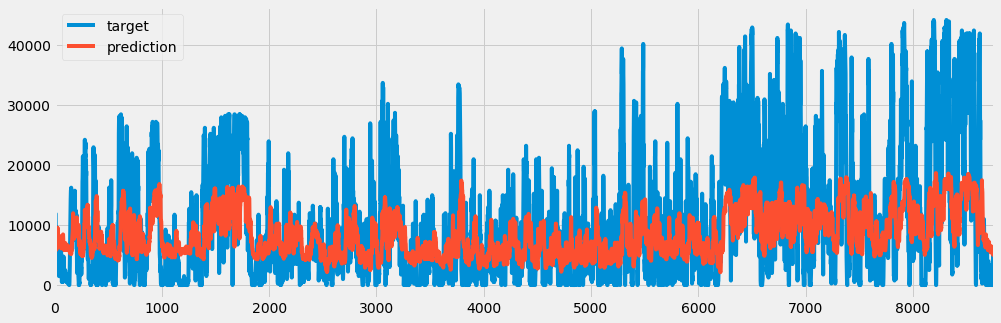

In [201]:
_ = test_result.reset_index(drop=True)[['target','prediction']].plot(figsize=(15, 5))

In [202]:
test_result['wind_mean_baseline']  = data.Wind_sum.mean()

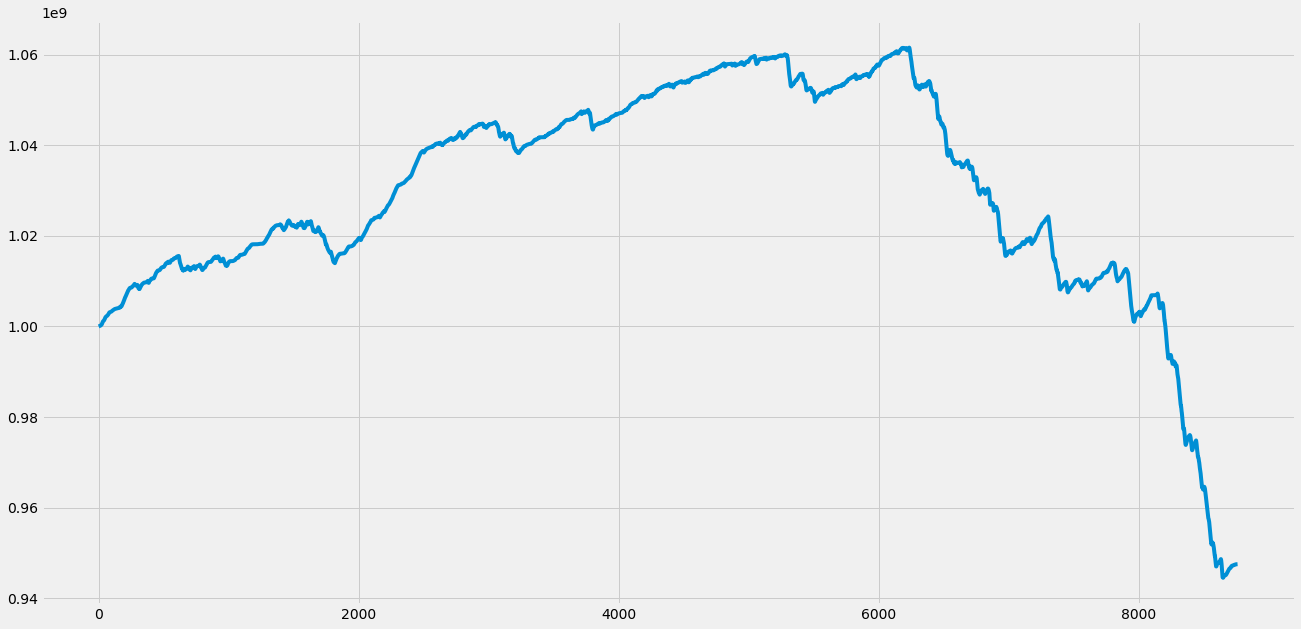

resultant budget:  947506168.9631851
net profit:  -52493831.03681493
number of short falling:  4398
number of panalty:  0


In [203]:
trading(test_result.Wind_sum, test_result.prediction)

In [106]:
explainer = shap.TreeExplainer(reg)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [54]:
shap_values = explainer.shap_values(Pool(X_train, y_train))

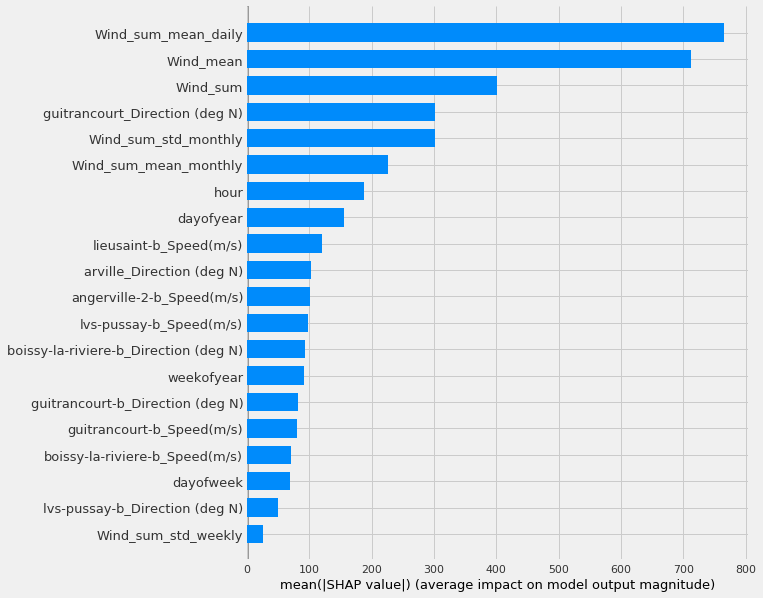

In [55]:
# feature importance plot
shap.summary_plot(shap_values, X_train, plot_type="bar")